# import module

In [1]:
from sklearn import tree
import pandas as pd
import numpy as np
import os as oss
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_validate, KFold, train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, make_scorer, f1_score, recall_score
from sklearn.preprocessing import MinMaxScaler, minmax_scale

import pydotplus, pprint
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier, CatBoost
import lightgbm as lgb
import xgboost as xgb
from tqdm import tqdm
import glob
import pickle

/home/nishiolab/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# load data

In [51]:
#neck_count=pd.read_csv("../../etc/neck_peak_num/clipped_std_features.csv")
step_count=pd.read_csv('../../etc/step_num_contSF/features.csv')
gradient=pd.read_csv('../../etc/gradient/features.csv')
datas=pd.read_csv('../../etc/windows_features/clipped_std_features.csv')

#datas=pd.read_csv('../../etc/step_num_contSF/features.csv')

datas['SC']=step_count['SC']
datas['SCF']=step_count['SCF']
datas['SCP']=step_count['SCP']
datas['gradient']=gradient['gradient']
#datas['PN']=gradient['PN']


#datas['count_05']=neck_count['count_05']
#datas['count_06']=neck_count['count_06']
#datas['count_07']=neck_count['count_07']
#datas['count_08']=neck_count['count_08']
#datas['count_09']=neck_count['count_09']

#datas['count_S']=step_count['SC']
#datas['count_M']=step_count['count_M']
#datas['count_O']=step_count['count_O']
#datas['count_1011']=step_count['count_1011']
#datas['count_1113']=step_count['count_1113']
#datas['count_14']=step_count['count_14']

datas=datas[datas['user']!="7NM9zimotoB"]
datas=datas[datas['user']!="7NM2zimotoD"]
datas=datas[datas['user']!="6NM9yossi"]

In [ ]:
datas=datas.replace({'pre_label': {'m ': 1}})
datas=datas.replace({'pre_label': {'s ': 0.5}})
datas=datas.replace({'pre_label': {'o ': 0}})
datas=datas.replace({'pre_label': {'no ': -1}})
datas=datas.replace({'pre_label': {'d ': -1}})
datas=datas.replace({'pre_label': {'f ': -1}})
datas=datas.replace({'pre_label': {'n ': -1}})

In [52]:
moving=datas[datas['label']=='m']
observing=datas[datas['label']=='o']
searching=datas[datas['label']=='s']

# change data format

In [183]:
# datas=pd.read_csv("../../etc/window3_features/clipped_std_features.csv")
df=datas[(datas['label']=='m') | (datas['label']=='s') | (datas['label']=='o')]
df['index']=0
df.loc[df['label']=='m', 'index']=1
df.loc[df['label']=='s', 'index']=2
df.loc[df['label']=='o', 'index']=3

#file_name='7NM8miyazaki'
#df_train=df[df['user']!='{}'.format(file_name)]
#df_test=df[df['user']=='{}'.format(file_name)]

df_train=df[(df['user']!='5NM7shibataku')&(df['user']!='7NM2zimotoB')&(df['user']!='7NM2zimotoD')&(df['user']!='6NM8kobeC')&(df['user']!='6NM3tamuchin') \
           &(df['user']!='7NM2zimotoC')&(df['user']!='5NM2tiger')&(df['user']!='5NMEXTRAharasho')&(df['user']!='6NM2tamuchin')&(df['user']!='6NM9senkita') \
           &(df['user']!='7NM9zimotoB')&(df['user']!='7NM1zimotoA')&(df['user']!='7NM2miyazaki')&(df['user']!='6NM8yahoo')&(df['user']!='6NM9yossi') \
           &(df['user']!='7NM4miyazaki')&(df['user']!='7NM9miyazaki')&(df['user']!='5NM8kan')&(df['user']!='6NM4tsubouchi')&(df['user']!='5NM1shibataku') \
           &(df['user']!='7NM6zimotoB')&(df['user']!='6NM9tamuchin')&(df['user']!='6NM6yahoo')&(df['user']!='6NM9nishio')&(df['user']!='5NM4tiger')]
"""
df_test=df[(df['user']=='5NM7shibataku')|(df['user']=='7NM2zimotoB')|(df['user']=='7NM2zimotoD')|(df['user']=='6NM8kobeC')|(df['user']=='6NM3tamuchin') \
           &(df['user']=='7NM2zimotoC')|(df['user']=='5NM2tiger')|(df['user']=='5NMEXTRAharasho')|(df['user']=='6NM2tamuchin')|(df['user']=='6NM9senkita') \
           &(df['user']=='7NM9zimotoB')|(df['user']=='7NM1zimotoA')|(df['user']=='7NM2miyazaki')|(df['user']=='6NM8yahoo')|(df['user']=='6NM9yossi') \
           &(df['user']=='7NM4miyazaki')|(df['user']=='7NM9miyazaki')|(df['user']=='5NM8kan')|(df['user']=='6NM4tsubouchi')|(df['user']=='5NM1shibataku') \
           &(df['user']=='7NM6zimotoB')|(df['user']=='6NM9tamuchin')|(df['user']=='6NM6yahoo')|(df['user']=='6NM9nishio')]
"""
# df_test=df[df['user']=='7NM2zimotoC']

/home/nishiolab/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nishiolab/.local/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


"\ndf_test=df[(df['user']=='5NM7shibataku')|(df['user']=='7NM2zimotoB')|(df['user']=='7NM2zimotoD')|(df['user']=='6NM8kobeC')|(df['user']=='6NM3tamuchin')            &(df['user']=='7NM2zimotoC')|(df['user']=='5NM2tiger')|(df['user']=='5NMEXTRAharasho')|(df['user']=='6NM2tamuchin')|(df['user']=='6NM9senkita')            &(df['user']=='7NM9zimotoB')|(df['user']=='7NM1zimotoA')|(df['user']=='7NM2miyazaki')|(df['user']=='6NM8yahoo')|(df['user']=='6NM9yossi')            &(df['user']=='7NM4miyazaki')|(df['user']=='7NM9miyazaki')|(df['user']=='5NM8kan')|(df['user']=='6NM4tsubouchi')|(df['user']=='5NM1shibataku')            &(df['user']=='7NM6zimotoB')|(df['user']=='6NM9tamuchin')|(df['user']=='6NM6yahoo')|(df['user']=='6NM9nishio')]\n"

In [184]:
df_test=df[df['user']=='5NM4tiger']

In [53]:
moving['index']=0
searching['index']=1
observing['index']=2

#moving['index2']=1
#searching['index2']=2
#observing['index2']=3

/home/nishiolab/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/nishiolab/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nishiolab/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [213]:
moving_train, moving_test=train_test_split(moving, train_size=6000, random_state=0)
observing_train, observing_test=train_test_split(observing, train_size=6000, random_state=0)
searching_train, searching_test=train_test_split(searching, train_size=6000, random_state=0)

In [5]:
user='5NM4tiger'
moving_test=moving[moving['user']==user]
moving_train=moving[moving['user']!=user]
observing_test=observing[observing['user']==user]
observing_train=observing[observing['user']!=user]
searching_test=searching[searching['user']==user]
searching_train=searching[searching['user']!=user]

In [54]:
df=pd.concat([moving, searching, observing])
#df=pd.concat([moving, searching])
Y=df['index']
#X=df[['SC', 'SCF', 'SCP', 'gradient']]
X=df[['acc_std_window0', 'acc_x_std_window0', 'gyro_y_std_window0',
       'gyro_x_std_window1', 'acc_y_std_window2', 'acc_z_std_window2',
       'acc_kurtosis_window3', 'acc_skewness_window3', 'acc_std_window3',
       'acc_z_std_window3', 'SC', 'SCF', 'SCP', 'gradient']]

In [214]:
df_train=pd.concat([moving_train, searching_train, observing_train])
df_test=pd.concat([moving_test, searching_test, observing_test])

In [230]:
#x_train=df_train.drop(['label', 'user', 'index', 'count_10', 'count_12'], axis=1)
x_train=df_train.drop(['label', 'user', 'index'], axis=1)
y_train=df_train['index']
#x_test=df_test.drop(['label', 'user', 'index', 'count_10', 'count_12'], axis=1)
x_test=df_test.drop(['label', 'user', 'index'], axis=1)
y_test=df_test['index']

In [219]:
x_train=x_train[['acc_std_window0', 'acc_x_std_window0', 'gyro_y_std_window0',
       'gyro_x_std_window1', 'acc_y_std_window2', 'acc_z_std_window2',
       'acc_kurtosis_window3', 'acc_skewness_window3', 'acc_std_window3',
       'acc_z_std_window3']]

In [220]:
x_test=x_test[['acc_std_window0', 'acc_x_std_window0', 'gyro_y_std_window0',
       'gyro_x_std_window1', 'acc_y_std_window2', 'acc_z_std_window2',
       'acc_kurtosis_window3', 'acc_skewness_window3', 'acc_std_window3',
       'acc_z_std_window3']]

# make model

In [ ]:
clf=tree.DecisionTreeClassifier(max_depth=5)
clf=clf.fit(x_train, y_train)

clf_q=tree.DecisionTreeClassifier(max_depth=5)
clf_q=clf_q.fit(x_train_q, y_train_q)

In [ ]:
predicted=clf.predict(x_test)

predicted_q=clf_q.predict(x_test_q)

In [ ]:
cm = confusion_matrix(y_test, predicted)
print(cm)

cm_q=confusion_matrix(y_test_q, predicted_q)
print(cm_q)

# Visualize Result

In [ ]:
dot_data=tree.export_graphviz(clf, out_file=None, feature_names=feature_names, class_names=['0','1','2'])

In [ ]:
graph=pydotplus.graph_from_dot_data(dot_data)
graph.progs = {'dot': u"C:\\Program Files (x86)\\Graphviz2.38\\bin\\dot.exe"}
Image(graph.create_png())

# SVM(one-rest)

In [55]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

In [ ]:
C = 1.
kernel = 'rbf'
gamma  = 0.01

estimator = SVC(C=C, kernel=kernel, gamma=gamma)
classifier = OneVsRestClassifier(estimator)
classifier.fit(x_train, y_train)
pred_y = classifier.predict(x_test)

In [ ]:
print ('One-versus-the-rest: {:.5f}'.format(accuracy_score(y_test, pred_y)))

confusion_matrix(y_test, pred_y)

In [56]:
clf = svm.SVC(kernel='rbf', gamma=0.6, C=0.6, class_weight='balanced')
classifer = OneVsRestClassifier(clf)

# 交差検証
scores = cross_val_score(classifer, X, Y, cv=10)
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
import numpy as np
print('Average score: {}'.format(np.mean(scores)))

Cross-Validation scores: [0.66344294 0.73075435 0.70444874 0.67917957 0.64473684 0.7000774
 0.66602167 0.77051084 0.73645511 0.65789474]
Average score: 0.6953522195806958


# L-SVC

In [6]:
from sklearn import svm, metrics, preprocessing
from sklearn.model_selection import cross_val_score

In [ ]:
svl1=svm.LinearSVC(loss='hinge', C=1.0, class_weight='balanced', random_state=0, max_iter=100000)
svl1.fit(x_train, y_train['index'])

In [ ]:
svl2=svm.LinearSVC(loss='hinge', C=1.0, class_weight='balanced', random_state=0, max_iter=100000)
svl2.fit(x_train2, y_train2['index2'])

In [ ]:
len([val for val in y_test['index'] if val==1])

In [ ]:
count=0
for i, k in enumerate(y_test['index']):
    if k==pre1[i] and k==1:
        count+=1
print(count)

In [ ]:
pre1=svl1.predict(x_test)
ac_score=metrics.accuracy_score(y_test['index'], pre1)
print(ac_score)

In [ ]:
a=[i for i in range(len(pre1)) if pre1[i]==0]

In [ ]:
x_test2=x_test.drop(x_test.index[a])

In [ ]:
y_test2=y_test.drop(x_test.index[a])

In [ ]:
pre2=svl2.predict(x_test2)
ac_score=metrics.accuracy_score(y_test2['index2'], pre2)
print(ac_score)

In [ ]:
scores=cross_val_score(svl, x_test, y_test, cv=10 ,n_jobs=-1)
print("平均正解率 = ", scores.mean())
print("正解率の標準偏差 = ", scores.std())

In [ ]:
pre=svl.predict(x_test)
ac_score=metrics.accuracy_score(y_test, pre)
print(ac_score)

In [ ]:
# std:0.6417859961664224
# mm:0.6437027849813959

In [ ]:
cm_svl = confusion_matrix(y_test, pre)
print(cm_svl)
#cm_q_svl=confusion_matrix(y_test_q, predicted_q)
#print(cm_q)

In [ ]:
clf=svm.LinearSVR(loss='hinge', C=1.0, random_state=0)
clf.fit(x_train, y_index_train)

In [209]:
3611/(3611+988+401)

0.7222

# SVM

In [49]:
clf = svm.SVC(kernel='rbf', gamma=0.6,C=1.0, class_weight='balanced')
clf.fit(x_train, y_train)

clf_pr=clf.predict(x_test)
ac_score=metrics.accuracy_score(y_test, clf_pr)

print(ac_score)
print(confusion_matrix(y_test, clf_pr))

NameError: name 'x_train' is not defined

In [191]:
df_new=pd.DataFrame()
df_new['label']=clf_pr
df_new.to_csv('../../etc/pred_label_20201111/{}pfg.csv'.format('5NM4tiger'), index=False)

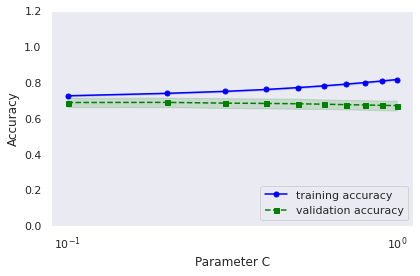

In [77]:
from sklearn.model_selection import validation_curve

clf = svm.SVC(kernel='rbf', C=1.0, class_weight='balanced')
param_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 ]

train_scores, test_scores = validation_curve(
                estimator=clf, 
                X=X, 
                y=Y, 
                param_name='gamma', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0, 1.2])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

In [50]:
# 交差検証
clf = svm.SVC(kernel='rbf', gamma=0.6, C=0.6, class_weight='balanced')
scores = cross_val_score(clf, X, Y, cv=10)
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
import numpy as np
print('Average score: {}'.format(np.mean(scores)))

Cross-Validation scores: [0.66537718 0.73075435 0.7098646  0.67956656 0.63931889 0.69698142
 0.66563467 0.76896285 0.73684211 0.66060372]
Average score: 0.6953906348246311


In [ ]:
with open('./model.pickle', mode='wb') as fp:
    pickle.dump(clf, fp)

In [ ]:
with open('./model.pickle', mode='rb') as fp:
    a=pickle.load(fp)

In [ ]:
clf_pr=clf.predict(x_test)
ac_score=metrics.accuracy_score(y_test, clf_pr)
print(ac_score)

# RVM

In [ ]:
from skrvm import RVC

In [ ]:
rvm=RVC()
rvm.fit(x_train, y_train)

# ロジスティック回帰

In [ ]:
from sklearn.model_selection import cross_val_score
logreg = LogisticRegression()
# 交差検証
scores = cross_val_score(logreg, iris.data, iris.target)
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
import numpy as np
print('Average score: {}'.format(np.mean(scores)))

In [ ]:
lr = LogisticRegression(random_state=0, max_iter=10000)
lr.fit(x_train, y_train)

In [ ]:
x_train.info()

In [ ]:
for c in lr.coef_:
    d = dict(zip(x_train.columns, c))
    d_top = sorted(d.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
    print(d_top)
    d_bottom = sorted(d.items(), key=lambda x: abs(x[1]), reverse=False)[:10]
    print(d_bottom)

In [ ]:
lr.coef_

In [ ]:
lr_pr=lr.predict(x_test)
ac_score=metrics.accuracy_score(y_test, lr_pr)
print(ac_score)

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10)
scores=cross_val_score(lr, X, Y, cv=kfold)
print('Cross-Validation scores: {}'.format(scores))

print('Average score: {}'.format(np.mean(scores)))

In [ ]:
confusion_matrix(y_test, lr_pr)

In [ ]:
a+=confusion_matrix(y_test, lr_pr)

In [ ]:
a=np.array([[0,0,0],[0,0,0],[0,0,0]])

# 多段階ロジスティック

## modelの作成

In [ ]:
datas=pd.read_csv("../../etc/dif_features/clipped_std_features.csv")

moving=datas[datas['label']=='m']
observing=datas[datas['label']=='o']
searching=datas[datas['label']=='s']

moving['index']=1
searching['index']=2
observing['index']=2

moving['index2']=1
searching['index2']=2
observing['index2']=3

In [ ]:
moving_test=moving[moving['user']=='7NM8miyazaki']
moving_train=moving[moving['user']!='7NM8miyazaki']
observing_test=observing[observing['user']=='7NM8miyazaki']
observing_train=observing[observing['user']!='7NM8miyazaki']
searching_test=searching[searching['user']=='7NM8miyazaki']
searching_train=searching[searching['user']!='7NM8miyazaki']

In [ ]:
df_train=pd.concat([moving_train, searching_train, observing_train])
df_test=pd.concat([moving_test, searching_test, observing_test])

x_train=df_train.drop(['label', 'user', 'index', 'index2'], axis=1)
y_train=df_train[['index']]
x_test=df_test.drop(['label', 'user', 'index', 'index2', 'pred_m', 'pred_s', 'pred_o'], axis=1)
y_test=df_test[['index', 'index2']]

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

lr_pr=lr.predict(x_train)

In [ ]:
df_train['pre_label']=lr_pr

In [ ]:
df_train2=df_train[~((df_train["label"]=='m') & (df_train['pre_label']==1))]

In [ ]:
x_train2=df_train2.drop(['label', 'user', 'index', 'index2', 'pre_label'], axis=1)
y_train2=df_train2[['index2']]

In [ ]:
lr2 = LogisticRegression(random_state=0)
lr2.fit(x_train2, y_train2)

## modelの適用

In [ ]:
result=pd.DataFrame(columns=['key', 'label'])

In [ ]:
lr_pr=lr.predict(x_test)

In [ ]:
x_test['label']=lr_pr

In [ ]:
result['key']=x_test.index
result['label']=lr_pr

In [ ]:
df_test2=x_test[x_test['label']!=1]

In [ ]:
df_test2['ans']=[y_test.loc[row_num]['index2'] for row_num in df_test2.index]

In [ ]:
x_test2=df_test2.drop(['label', 'ans'], axis=1)
y_test2=df_test2['ans']

In [ ]:
lr2_pr=lr2.predict(x_test2)

In [ ]:
for row_num, label in zip(x_test2.index, lr2_pr):
    result.loc[(result['key']==row_num), 'label']=label

In [ ]:
metrics.accuracy_score(result['label'].values, y_test['index2'])

In [ ]:
ac_score=metrics.accuracy_score(y_test['index'], lr_pr)
print(ac_score)

In [ ]:
ac_score=metrics.accuracy_score(y_train['index'], lr_pr)
print(ac_score)

In [ ]:
ac_score=metrics.accuracy_score(y_test2, lr2_pr)
print(ac_score)

In [ ]:
confusion_matrix(y_test['index2'], result['label'])

# GBDT

In [ ]:
scoring = {'accuracy': make_scorer(accuracy_score),
           'kappa': make_scorer(cohen_kappa_score)
          }
skf = StratifiedKFold(n_splits=10,
                      shuffle=False,
                      random_state=0)

In [ ]:
model = CatBoostClassifier(iterations=500, 
                           eval_metric = 'Kappa',
                           learning_rate=0.01, 
                           l2_leaf_reg = 9,
                           depth=10,
                           one_hot_max_size = 50,
                           loss_function='Logloss')

scores_cat = cross_validate(model, 
                        x_train,   # 
                        y_train,
                        cv=skf, 
                        n_jobs = -1,
                        scoring=scoring)
pprint.pprint("CatBoost:{}".format(scores_cat))
pprint.pprint("CatBoost_accuracy:{}".format(scores_cat["test_accuracy"].mean()))
pprint.pprint("CatBoost_kappa:{}".format(scores_cat["test_kappa"].mean()))

In [124]:
params = {
        'loss_function': 'MultiClass',
        'num_boost_round': 5000,
        'early_stopping_rounds': 10,
        'silent':True}

model = CatBoost(params)
model.fit(x_train, y_train)

y_pred = model.predict(x_test, prediction_type='Class')

acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

Accuracy: 0.7652683921968635


In [ ]:
y_pred = model.predict(x_test, prediction_type='Class')

acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
df=pd.DataFrame(lr_pr, columns=['label'])

In [ ]:
df.to_csv('../../etc/win3_7NM8miyazaki.csv', header=None, index=None)

In [ ]:
params = {
        'loss_function': 'MultiClass',
        'num_boost_round': 5000,
        'early_stopping_rounds': 10,
    }

# model_nopre = CatBoost(params)
# model_nopre.fit(x_train, y_train)

y_pred = model_nopre.predict(x_test, prediction_type='Class')

acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

# user単位でのテスト

In [ ]:
xt=np.asarray(x_test)
yt=np.asarray(y_test)

In [ ]:
np.append(xt[0], [0,0,0])

In [ ]:
model.predict(np.append(xt[0], [0,0,0]), prediction_type='Class')[0]

In [ ]:
index=0
mm=0
ms=0
mo=0
sm=0
ss=0
so=0
om=0
os=0
oo=0

for row in xt:
    if index==0:
        row=np.append(row, [1,0,0])
        pred=label=model.predict(row, prediction_type='Probability')
        label=model.predict(row, prediction_type='Class')
        index+=1
        continue
    row=np.append(row, pred)
    pred=model.predict(row, prediction_type='Probability')
    label=model.predict(row, prediction_type='Class')
    print('label:{}'.format(label[0]))
    print('\n')
    if yt[index][0]==1 and label[0]==1:
        mm+=1
    elif yt[index][0]==1 and label[0]==2:
        ms+=1
    elif yt[index][0]==1 and label[0]==3:
        mo+=1
    elif yt[index][0]==2 and label[0]==1:
        sm+=1
    elif yt[index][0]==2 and label[0]==2:
        ss+=1
    elif yt[index][0]==2 and label[0]==3:
        so+=1
    elif yt[index][0]==3 and label[0]==1:
        om+=1
    elif yt[index][0]==3 and label[0]==2:
        os+=1
    elif yt[index][0]==3 and label[0]==3:
        oo+=1
    index+=1

In [ ]:
print(mm, ms, mo)
print(sm, ss, so)
print(om, os, oo)

In [ ]:
mm=0
ms=0
mo=0
sm=0
ss=0
so=0
om=0
os=0
oo=0

In [ ]:
params = {
        'loss_function': 'MultiClass',
        'num_boost_round': 5000,
        'early_stopping_rounds': 10,
    }
a=np.array([[0,0,0],[0,0,0],[0,0,0]])

datas=pd.read_csv("../../etc/pred_features/features.csv")
df=datas[(datas['label']=='m') | (datas['label']=='s') | (datas['label']=='o')]
df['index']=0
df.loc[df['label']=='m', 'index']=1
df.loc[df['label']=='s', 'index']=2
df.loc[df['label']=='o', 'index']=3

for file in glob.glob("../../etc/label/*.csv"):
    file_name=oss.path.basename(file).split(".csv")[0]

    df_train=df[df['user']!='{}'.format(file_name)]
    df_test=df[df['user']=='{}'.format(file_name)]
    
    x_train=df_train.drop(['label', 'user', 'index'], axis=1)
    y_train=df_train[['index']]
    x_test=df_test.drop(['label', 'user', 'index', 'pred_m', 'pred_s', 'pred_o'], axis=1)
    y_test=df_test[['index']]
    
    model = CatBoost(params)
    model.fit(x_train, y_train)
    
    index=0
    xt=np.asarray(x_test)
    yt=np.asarray(y_test)
    
    for row in xt:
        if index==0:
            row=np.append(row, [1,0,0])
            pred=label=model.predict(row, prediction_type='Probability')
            label=model.predict(row, prediction_type='Class')
            index+=1
            continue
        row=np.append(row, pred)
        pred=model.predict(row, prediction_type='Probability')
        label=model.predict(row, prediction_type='Class')
        print('label:{}'.format(label[0]))
        print('\n')
        if yt[index][0]==1 and label[0]==1:
            mm+=1
        elif yt[index][0]==1 and label[0]==2:
            ms+=1
        elif yt[index][0]==1 and label[0]==3:
            mo+=1
        elif yt[index][0]==2 and label[0]==1:
            sm+=1
        elif yt[index][0]==2 and label[0]==2:
            ss+=1
        elif yt[index][0]==2 and label[0]==3:
            so+=1
        elif yt[index][0]==3 and label[0]==1:
            om+=1
        elif yt[index][0]==3 and label[0]==2:
            os+=1
        elif yt[index][0]==3 and label[0]==3:
            oo+=1
        index+=1
"""
    y_pred = model.predict(x_test, prediction_type='Class')

    acc = accuracy_score(y_test, y_pred)
    print('Accuracy:', acc)
    
    a+=confusion_matrix(y_test, y_pred)"""
    

In [ ]:
print(a+np.array([[2569, 555, 242], [743, 626, 429], [276, 318, 1645]]))

In [ ]:
for f, v in zip(feature_importance, x_train.columns):
    print(f, v)

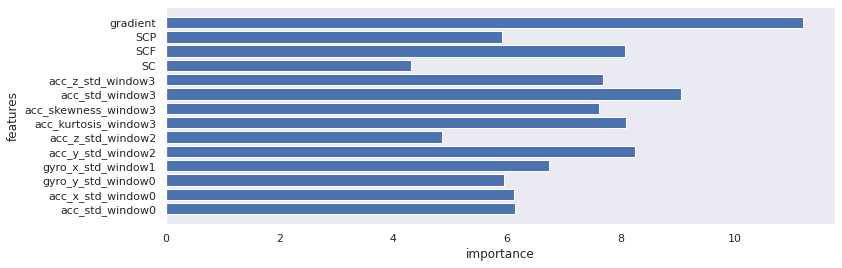

In [125]:
feature_importance = model.get_feature_importance()
# 棒グラフとしてプロットする
plt.figure(figsize=(12, 4))
plt.barh(range(len(feature_importance)),
        feature_importance,
        tick_label=x_train.columns)

plt.xlabel('importance')
plt.ylabel('features')
plt.grid()
plt.show()

# 推定値を特徴量へ

In [ ]:
df_train['index']=0

In [ ]:
df_train.loc[df_train['label']=='o', 'index']=3

In [ ]:
params = {
        'loss_function': 'MultiClass',
        'num_boost_round': 5000,
        'early_stopping_rounds': 10,
    }

datas=pd.read_csv("../../etc/window3_features/clipped_std_features.csv")
df=datas[(datas['label']=='m') | (datas['label']=='s') | (datas['label']=='o')]
df['index']=0
df.loc[df['label']=='m', 'index']=1
df.loc[df['label']=='s', 'index']=2
df.loc[df['label']=='o', 'index']=3

for file in glob.glob("../../etc/label/*.csv"):
    # 同一ファイル内のすべてのcsvファイルの名前を取得
    file_name=os.path.basename(file).split(".csv")[0]

    df_train=df[df['user']!='{}'.format(file_name)]
    df_test=df[df['user']=='{}'.format(file_name)]

    x_train=df_train.drop(['label', 'user', 'index'], axis=1)
    y_train=df_train[['index']]
    x_test=df_test.drop(['label', 'user', 'index'], axis=1)
    y_test=df_test[['index']]

    model = CatBoost(params)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test, prediction_type='Probability')
    y_pred=np.append(np.array([[0,0,0]]), y_pred, axis=0)[:-1]
    df_test['pred_m']=y_pred[:, 0]
    df_test['pred_s']=y_pred[:, 1]
    df_test['pred_o']=y_pred[:, 2]

    df_test.to_csv('../../etc/pred_features/{}.csv'.format(file_name), index=False)    

In [ ]:
len(user)

In [ ]:
df_test['x']=y_pred.reshape(3, len(y_pred))[0]

In [ ]:
a=np.append(np.array([[0,0,0]]), y_pred, axis=0)

# パラメータ決定

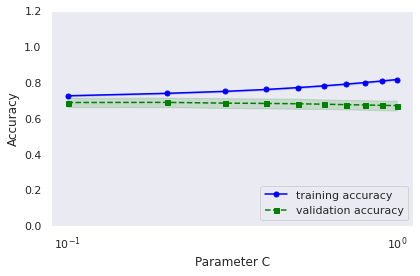

In [77]:
from sklearn.model_selection import validation_curve

clf = svm.SVC(kernel='rbf', C=1.0, class_weight='balanced')
param_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 ]

train_scores, test_scores = validation_curve(
                estimator=clf, 
                X=X, 
                y=Y, 
                param_name='gamma', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0, 1.2])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()